In [ ]:
# default_exp plot_light

In [ ]:
#hide

from nbdev.showdoc import *
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as md
import matplotlib as mpl

from datetime import time

# Plot Light

> Module takes light data processed by 'analyze_by_person and outputs
plots of the light data based on time of day. Comparitive plotting (multiple visits
or even multiple participants) is also possible.

## How to Plot Light

Three types of plots are creatable using plot_light, each serving a different purpose. 

Since light exposure for a given time of day is not normally distributed (in fact, it tends to be exponential), a preferred measure of central tendency is quartiles. To plot this, selecting top plot as "quantiles" will present the interquartile range of light exposure. 

Top plot can also be set to "counts", which gives the amount of data present. This is helpful in examining the data for particular patient behavior. One such use case would be viewing people who are tend to stay up late at night.

Setting top plot to "mean/sem" gives a graph of the mean amount of light over the course of a day. This is particularly useful to find strong outliers, which may be physiologically relevant.

In [ ]:
#export
def plot_light(d_list, l_list, palette,
               toplot = "mean/sem",
               y_lim = 2500, y_label = "Lux"):
    
    """ Creates various light plots to aggregate data based on time of day.
    
    #### Parameters
    
    d_list: list
    
        A list of series of light data for plotting.
    l_list: list
        
        A list of labels corresponding how you'd like each series in d_list to be labeled.
    palette:sns.color_palette
    
        Seaborn color palette for plots
    toplot: str
        
        The type of plot you'd like to create. Default is "mean/sem". Other choices are 
        "counts", and "quantiles"
    y_limit: int
    
        Desired default range for y_limit of the outputted plots.
    y_label: str

        Desired label for the y-axis of outputted plots.
    """
    
    # number of labels and corresponding series must match
    assert ( len(d_list) == len(l_list) )
    dm = []
    dlo = []
    dhi = []
    tinc = 200
    
    if toplot == "mean/sem":
        for d in d_list:
            dm.append(pd.Series(d.mean()).sort_index())
            tmp = pd.Series(d.sem()).sort_index()
            dlo.append( dm[-1] - tmp )
            dhi.append( dm[-1] + tmp )
            
    elif toplot == "counts":
        tinc = 5000
        toplot = ''
        y_label = "Number of samples "
        func = lambda x: x.max().to_frame().shape[0]
        y_choices = [func(x) for x in d_list]
        y_lim = np.max(y_choices) * 10
        for d in d_list:
            dm.append( d.count().sort_index() )
            dlo.append( dm[-1] )
            dhi.append( dm[-1] )
            
    elif toplot=="quantiles":
        for d in d_list:
            dm.append( d.median().sort_index() )
            dlo.append( d.quantile(0.25).sort_index() )
            dhi.append( d.quantile(0.75).sort_index() )
    else:
        print("What do you want to plot? Valid options include:")
        print("mean/sem , counts , quantiles")
        return
    
    plt.figure(figsize=(8,6))
    ax=plt.gca()
    
    pidx = 0
    for mid, lo, hi, lab in zip(dm,dlo,dhi,l_list):
        cval = mpl.colors.to_hex( palette[pidx] )
        pidx = pidx + 1
        timval = [ pd.Timestamp(av.isoformat()) for av in mid.index.tolist() ]
               
        vals = pd.DataFrame( mid )
        vals['time']=vals.index.to_series()
        vals['mins']=vals.time.apply(lambda x: x.second/60.0 + x.minute + x.hour*60.0)
        vals['lux-mins']=vals['White Light']*vals['mins']
        v = vals['lux-mins'].dropna().mean()/vals['White Light'].dropna().mean()
        hrs = int(v/1440*24)
        mins = int( (v - hrs*60) )
        tmid = time( hrs, mins)
        print ('{} - cumulative {}*sec: {:e}, center of mass of light exposure: {}'.format(lab,y_label.strip(),mid.sum()*20,tmid))
        lab = lab+'\n{:4.3e} lx*s, COLE {}'.format(mid.sum()*20,tmid)
        
        ax.plot(timval, mid.values, color=cval, label=lab)
        ax.fill_between(timval, hi.values, lo.values, color=cval, alpha=0.33)
        
    ax.legend()

    # format the ticks
    tFmt = md.DateFormatter('%H:%M')
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(0,24,4)))
    ax.xaxis.set_major_formatter(tFmt)
    ax.set_ylim(0,y_lim)
    ax.yaxis.set_ticks(np.arange(tinc,y_lim,tinc))

    ax.grid(True)
    plt.ylabel(y_label + toplot)
    plt.xlabel('Time of day')


In [ ]:
show_doc(plot_light, title_level = 3)

<h3 id="plot_light" class="doc_header"><code>plot_light</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_light</code>(**`d_list`**, **`l_list`**, **`palette`**, **`toplot`**=*`'mean/sem'`*, **`y_lim`**=*`2500`*, **`y_label`**=*`'Lux'`*)

Creates various light plots to aggregate data based on time of day.

#### Parameters

d_list: list

    A list of series of light data for plotting.
l_list: list
    
    A list of labels corresponding how you'd like each series in d_list to be labeled.
palette:sns.color_palette

    Seaborn color palette for plots
toplot: str
    
    The type of plot you'd like to create. Default is "mean/sem". Other choices are 
    "counts", and "quantiles"
y_limit: int

    Desired default range for y_limit of the outputted plots.
y_label: str

    Desired label for the y-axis of outputted plots.

## Example

This example illustrates how to go from data processed by 'analyze_by_person' to plotted light data.

Start by reading the processed parquet files.

In [ ]:
file_prefix = "example_output/"

In [ ]:
all_data = pd.read_parquet(file_prefix+'raw.parquet')
all_data.dropna().head()

,Off-Wrist Status,Activity,Marker,White Light,Red Light,Green Light,Blue Light,Sleep/Wake,Interval Status,UID,Group
DateTime,,,,,,,,,,,
2018-06-25 12:31:00,0,0.0,0.0,37.09,28.4,15.5,14.5,1.0,ACTIVE,base_v1\user1234,base_
2018-06-25 12:31:30,0,170.0,0.0,156.15,159.0,59.9,65.3,1.0,ACTIVE,base_v1\user1234,base_
2018-06-25 12:32:00,0,194.0,0.0,149.03,113.0,49.8,50.6,1.0,ACTIVE,base_v1\user1234,base_
2018-06-25 12:32:30,0,0.0,0.0,473.95,365.0,161.0,161.0,1.0,ACTIVE,base_v1\user1234,base_
2018-06-25 12:33:00,0,62.0,0.0,317.82,264.0,112.0,115.0,1.0,ACTIVE,base_v1\user1234,base_


In this particular example analysis, we're formatting times to the nearest quarter-hour and then filtering data based on a set of requirements.

1. The watch must be On-Wrist

2. The interval status must be either 'ACTIVE' or 'REST'

3. The White Light reading must be at least 1.0. Lower light readings tend to be less accurate, and
   potentially noisy.
   
Afterwards, any quarter-hours with under 50 valid light readings are ommitted.

In [ ]:
def quarter_hourly(dtime):
    tm = pd.to_datetime('{}:{:02d}'.format(dtime.hour,(dtime.minute//15)*15))
    return tm.time()

In [ ]:
these_rows = np.logical_and( np.logical_not(all_data['Off-Wrist Status']), np.logical_and( all_data['Interval Status'].isin(['ACTIVE','REST']), all_data['White Light']>1.0) ) 
for agroup in all_data.Group.unique():
    print(agroup)
    theones = (all_data.Group == agroup) & (these_rows)
    exec('{} = all_data[theones].dropna().groupby(quarter_hourly).filter(lambda x: x["White Light"].count()>50,dropna=False).groupby(quarter_hourly)'.format(agroup.replace(' ','_'),  ))

base_
follow_up_


base_ - cumulative Lux*sec: 1.110292e+06, center of mass of light exposure: 13:35:00
follow_up_ - cumulative Lux*sec: 1.258620e+06, center of mass of light exposure: 12:45:00


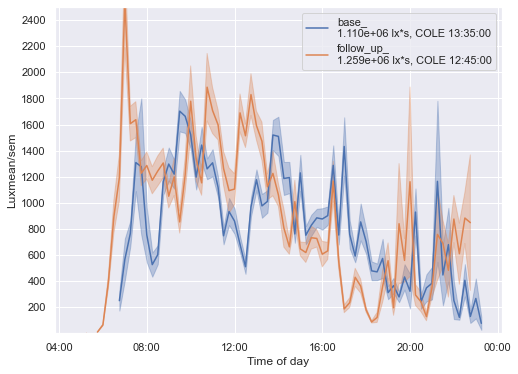

In [ ]:
sns.set(style="darkgrid")
plot_light([base_["White Light"], follow_up_["White Light"]], ["base_", "follow_up_"], palette=sns.color_palette("deep"))

base_ - cumulative Number of samples*sec: 3.976200e+05, center of mass of light exposure: 13:58:00
follow_up_ - cumulative Number of samples*sec: 3.824600e+05, center of mass of light exposure: 13:31:00


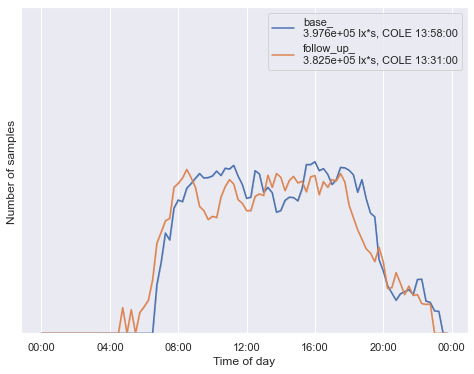

In [ ]:
plot_light([base_["White Light"], follow_up_["White Light"]], ["base_", "follow_up_"], toplot = "counts", palette=sns.color_palette("deep"))

base_ - cumulative Lux*sec: 2.590423e+05, center of mass of light exposure: 13:09:00
follow_up_ - cumulative Lux*sec: 3.524821e+05, center of mass of light exposure: 12:00:00


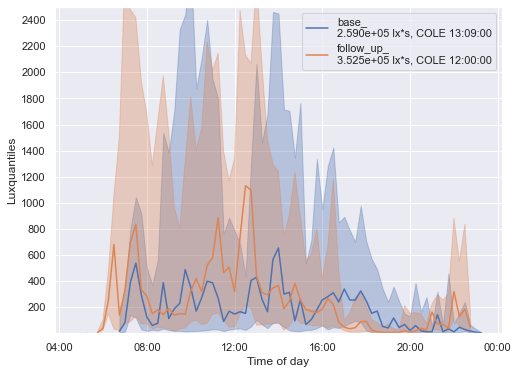

In [ ]:
plot_light([base_["White Light"], follow_up_["White Light"]], ["base_", "follow_up_"], toplot = "quantiles", palette=sns.color_palette("deep"))